# Predict unobserved product properties by help of machine learning

In [2]:
# Standard imports
import numpy as np
import os
import itertools
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
# Scikit learn imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
# Get a colormap
cm = plt.cm.get_cmap('RdYlGn')

## Method to plot a 3D-decision plane

In [3]:
# Plot the decision plane between two classes
def plot_svc_decision_plane(ax, svm_clf, xmin, xmax, ymin, ymax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0 * x + w1*y + w2 * z + b = 0
    # => z = -w0/w2 * x -w1/w2 * y  - b/w2
    x = np.linspace(xmin, xmax, 10)
    y = np.linspace(ymin, ymax, 10)
    [X, Y] = np.meshgrid(x, y)
    decision_boundary = -w[0]/w[2] * X - w[1]/w[2] * Y - b/w[2]

    #svs = svm_clf.support_vectors_
    #plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    ax.plot_wireframe(X, Y, decision_boundary)#, "k-", linewidth=2)

In [4]:
# Minimum acceptable force
Fmin = 18000

In [5]:
# Load data
SpringPB = pd.read_csv(os.path.join("SpringPBData.csv"))
# Initialise scaler
scaler = StandardScaler()
# Data selection
X = SpringPB[['l', 'h1', 'h2']]
# Scale data
X = scaler.fit_transform(X)
# Label training data
y = (SpringPB['F'] > Fmin)*1.0
# Initialise support vector machine
svm_clf = SVC(kernel="linear", C = 1e2, class_weight = {1: 1, 0: 1e6})
# Fit SVM
svm_clf.fit(X, y)

SVC(C=100.0, cache_size=200, class_weight={0: 1000000.0, 1: 1}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

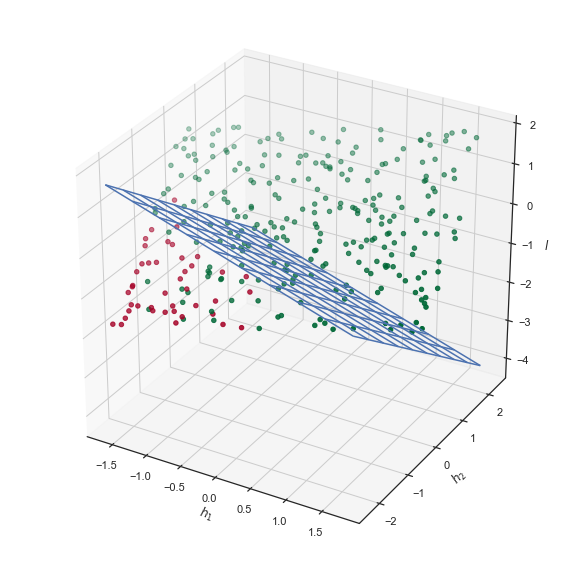

In [6]:
sns.set()
# Plot 3D scatter with decision boundary
from mpl_toolkits.mplot3d import Axes3D
x = X[:,1]#SpringPB["h1"]
y = X[:,2]#SpringPB["h2"]
z = X[:,0]#SpringPB["l"]
c = (SpringPB["F"]>Fmin)*1.0

with sns.axes_style('white'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c = c, cmap = cm)
    plot_svc_decision_plane(ax, svm_clf, min(x), max(x), min(y), max(y))
    ax.set_xlabel('$h_1$')
    ax.set_ylabel('$h_2$')
    ax.set_zlabel('$l$')

## Test on unseen data!

Pregenerated data

In [ ]:
SpringPBval = pd.read_csv(os.path.join("SpringPBDataValidation.csv"))
Xval = SpringPBval[['l', 'h1', 'h2']]
Xval_scaled = scaler.transform(Xval)
# Predict force outcome acc. to SVM
Fconf_pred = np.reshape((svm_clf.predict(Xval_scaled) == 1), (len(Xval), 1))
# True force outcome for comparison
Fconf_true = (SpringPBval['F'] > Fmin)

Alternatively: generate data by MC simulation

In [9]:
# Generate unseen test data
Nval = 10000
dval = 0.05*np.random.rand(Nval,1)-.025
lval = 0.1*np.random.rand(Nval,1)-.05
#h1 = np.concatenate((0.1*np.random.rand(np.int(N/2),1)+.2, 0.1*np.random.rand(np.int(N/2),1)-.2))
h1val = 0.1*np.random.rand(Nval,1)-.05
h2val = lval + h1val
#h2 = 0.1*np.random.rand(N,1)
#h2 = -h1*(1+0.1*(np.random.rand(N,1)-0.05))
cval = 20000+300*np.random.randn(Nval,1)
Fval = cval*(1+(h1val+lval+dval+h2val))
Xval = np.concatenate((lval[:], h1val[:], h2val[:]), axis = 1)
# Scale withidentical scaler
Xval_scaled = scaler.transform(Xval)
# Predict force outcome acc. to SVM
Fconf_pred = np.reshape((svm_clf.predict(Xval_scaled) == 1), (Nval, 1))
# True force outcome for comparison
Fconf_true = (Fval > Fmin)

Inspect confusion matrix

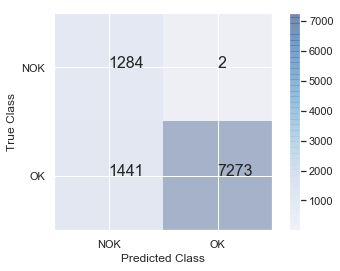

In [10]:
conf_mat = confusion_matrix(Fconf_true, Fconf_pred)
plt.imshow(conf_mat, cmap = plt.cm.Blues, alpha = 0.3)
plt.colorbar()
plt.xticks((0, 1), ("NOK", "OK"))
plt.yticks((0, 1), ("NOK", "OK"))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
for i,j in itertools.product((0,1), (0,1)):
    plt.text(j,i, conf_mat[i,j], fontsize = 16)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f0ef898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1f6f5048>]], dtype=object)

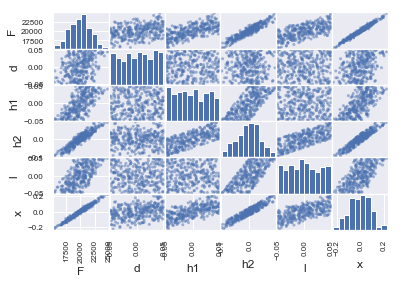

In [13]:
scatter_matrix(SpringPB)